In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
Input ={"num_plaintext":500,"num_byte":8,"num_bits":8,"num_iteration":5}

In [3]:
def hamming_distance(x,y):
    return bin(x^y).count("1")
def hamming_weight(x):
    return bin(x).count("1")

In [4]:
inv_s_box = np.array(pd.read_csv("C:/Users/Ziyue/Dropbox/TonyShared/CPA/inv_s_box.csv",header=None))[0]
s_box = list(np.zeros(2**Input["num_bits"]))
for i in range(0,2**Input["num_bits"]):
    s_box[i] = int(np.where(inv_s_box == i)[0][0])

In [5]:
#Create random correct key, random plain text, sample HW
rv_range = list(range(0,2**Input["num_bits"]))
True_key = np.random.choice(rv_range, size=Input["num_byte"], replace = True)
Noise_variance = [10,8,12,10,5,2,13,20]
Sample_HW = np.zeros((Input["num_byte"],2**Input["num_bits"],Input["num_plaintext"]))
plain_text = np.random.choice(rv_range, size=Input["num_plaintext"], replace = True)
for k in range(0,Input["num_byte"]):
    for i in range(0,2**Input["num_bits"]):
        for j in range(0,Input["num_plaintext"]):
            Sample_HW[k,i,j] = hamming_weight(s_box[i^plain_text[j]])

In [12]:
#Create Gaussian simulated traces based on sample HW:
Simulated_traces = np.zeros((Input["num_byte"],Input["num_plaintext"]))
Simulated_traces_Lap = np.zeros((Input["num_byte"],Input["num_plaintext"]))
post_pro_vector = np.zeros((Input["num_byte"],2**Input["num_bits"]))
post_pro_vector_Lap = np.zeros((Input["num_byte"],2**Input["num_bits"]))
sorted_post_pro_vector = np.zeros((Input["num_byte"],2**Input["num_bits"]))
sorted_post_pro_vector_Lap = np.zeros((Input["num_byte"],2**Input["num_bits"]))
for k in range(0,Input["num_byte"]):
    for i in range(0,Input["num_plaintext"]):
        Simulated_traces[k,i] = Sample_HW[k,True_key[k],i] + np.random.normal(0,Noise_variance[k]**0.5)
        Simulated_traces_Lap[k,i] = Sample_HW[k,True_key[k],i] + np.random.laplace(0,(0.5*Noise_variance[k])**0.5)

In [6]:
def prior_pro(data_point,sample_HW,key,var):
    n = len(data_point)
    P = 1
    for w in range(0,n):
        P = P * norm.pdf(data_point[w], sample_HW[key,w], var**0.5)*18
    return P

def post_pro(data_point,sample_HW,key,var):
    sums = 0
    for i in range(0,2**Input["num_bits"]):
        sums = sums + prior_pro(data_point,sample_HW,i,var)
    pro = prior_pro(data_point,sample_HW,key,var)/sums
    return pro

In [172]:
for k in range(0,Input["num_byte"]):
    for i in range(0,2**Input["num_bits"]):
        post_pro_vector[k,i] = post_pro(Simulated_traces[k,:],Sample_HW[k,:,:],i,Noise_variance[k])
        post_pro_vector_Lap[k,i] = post_pro(Simulated_traces_Lap[k,:],Sample_HW[k,:,:],i,Noise_variance[k])
for i in range(0,Input["num_byte"]):
    sorted_post_pro_vector[i,:] = sorted(post_pro_vector[i,:],reverse = True)
    sorted_post_pro_vector_Lap[i,:] = sorted(post_pro_vector_Lap[i,:],reverse = True)

NameError: name 'Simulated_traces_Lap' is not defined

In [16]:
pd.DataFrame(post_pro_vector).to_csv("post_pro_vector.csv")
pd.DataFrame(post_pro_vector_Lap).to_csv("post_pro_vector_Lap.csv")

In [25]:
post_pro_vector = np.array(pd.read_csv("C:/Users/Ziyue/Desktop/document/jupyter_test/post_pro_vector.csv",header=None))[1:,1:]

In [239]:
#Confusion coefficient
confusion_cof = np.zeros((2**Input["num_bits"],2**Input["num_bits"]))
for i in range(0,2**Input["num_bits"]-1):
    for j in range(i+1,2**Input["num_bits"]):
        sum = 0
        for k in range(0,2**Input["num_bits"]):
            sum += (hamming_weight(s_box[k^i])-hamming_weight(s_box[k^j]))**2
        confusion_cof[i,j]=sum/256
for i in range(0,2**Input["num_bits"]-1):
    for j in range(i+1,2**Input["num_bits"]):
        confusion_cof[j,i]=confusion_cof[i,j]

In [240]:
#K_matrix
def K_matrix_kc(kc,confusion_cof):
    K = np.zeros((2**Input["num_bits"]-1,2**Input["num_bits"]-1))
    index = list(range(0,2**Input["num_bits"]))
    index.pop(kc)
    for i in range(0,2**Input["num_bits"]-1):
        K[i,i] = confusion_cof[kc,index[i]]
    for k in range(0,2**Input["num_bits"]-2):
        for j in range(k+1,2**Input["num_bits"]-1):
            K[k,j] = (confusion_cof[kc,index[k]]+confusion_cof[kc,index[j]]-confusion_cof[index[k],index[j]])/2
    for i in range(0,2**Input["num_bits"]-2):
        for j in range(i+1,2**Input["num_bits"]-1):
            K[j,i] = K[i,j]
    return K

In [241]:
#n correspond to number of power traces we may have
#number is the number of sample to estimate real probability#
def Compute_theo_pro(n,number,k_matrix,miu):
    sample = np.random.multivariate_normal([x*n**0.5 for x in miu],k_matrix,size = number)
    num_negative = np.zeros(number)
    ratio_vector = np.zeros(2**Input["num_bits"])
    for i in range(0,number):
        num_negative[i] = 255 - len(list(filter(lambda x: x > 0, sample[i,:])))
    for i in range(0,2**Input["num_bits"]):
        ratio_vector[i] = len(list(filter(lambda x: x == i, num_negative)))/number
    return ratio_vector

In [249]:
#One byte case : take first byte
Num_traces=[1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
theo_GM = np.zeros(len(Num_traces))
avg_GM = np.zeros(len(Num_traces))
avg_GE = np.zeros(len(Num_traces))
avg_GE_Lap = np.zeros(len(Num_traces))
avg_GM_Lap = np.zeros(len(Num_traces))
avg_up = np.zeros(len(Num_traces))
avg_up_Lap = np.zeros(len(Num_traces))
avg_low = np.zeros(len(Num_traces))
avg_low_Lap = np.zeros(len(Num_traces))
theo_up = np.zeros(len(Num_traces))
theo_low = np.zeros(len(Num_traces))
up_GMHK = np.zeros(len(Num_traces))
low_GMHK = np.zeros(len(Num_traces))
up_GMHK_Lap = np.zeros(len(Num_traces))
low_GMHK_Lap = np.zeros(len(Num_traces))
theo_up_GMHK = np.zeros(len(Num_traces))
theo_low_GMHK = np.zeros(len(Num_traces))

In [256]:
def rank_estimation_single_bit(N,Input,confusion_cof):
    GM_vector = np.zeros(Input["num_iteration"])
    GM_vector_Lap = np.zeros(Input["num_iteration"])
    GE_vector = np.zeros(Input["num_iteration"])
    GE_vector_Lap = np.zeros(Input["num_iteration"])
    H = 0
    H_Lap = 0
    inter = np.zeros(Input["num_iteration"]) 
    inter_Lap = np.zeros(Input["num_iteration"])
    lower_bound = np.zeros(Input["num_iteration"]) 
    upper_bound = np.zeros(Input["num_iteration"]) 
    lower_bound_Lap = np.zeros(Input["num_iteration"]) 
    upper_bound_Lap = np.zeros(Input["num_iteration"]) 
    Simulated_trace = np.zeros(N)
    Simulated_trace_Lap = np.zeros(N)
    Sample_HW = np.zeros((2**Input["num_bits"],N))
    kc = int(np.random.choice(rv_range, size=1)[0])
    #theo part
    miu = list(confusion_cof[kc,:]/(2*Noise_variance[0]**0.5))
    miu.pop(kc)
    K_matrix = K_matrix_kc(kc,confusion_cof)
    theo_pro = Compute_theo_pro(N,10000,K_matrix,miu)
    sorted_theo_pro = sorted(theo_pro,reverse = True)
    theo_GM = 0
    theo_inter = 0
    theo_H_K = 0
    for i in range(0,2**Input["num_bits"]):
        theo_GM += (i+1)*sorted_theo_pro[i]
        theo_inter += (sorted_theo_pro[i])**0.5
        theo_H_K -= sorted_theo_pro[i]*math.log(max(sorted_theo_pro[i],0.000000001),2)
    theo_up = 0.5*theo_inter**2+0.5
    theo_low = (theo_inter**2)/(1+math.log(2**Input["num_bits"]))
    theo_up_GMHK = 1 + (2**Input["num_bits"] - 1)*(theo_H_K)/(2*math.log(2**Input["num_bits"]))
    theo_low_GMHK = 2**(theo_H_K-2)+1
    for k in range(0,Input["num_iteration"]):
        plain_text = np.random.choice(rv_range, size=N, replace = True)
        for i in range(0,2**Input["num_bits"]):
            for j in range(0,N):
                Sample_HW[i,j] = hamming_weight(s_box[i^plain_text[j]])
        for i in range(0,N):
            Simulated_trace[i] = Sample_HW[kc,i] + np.random.normal(0,Noise_variance[0]**0.5)
            Simulated_trace_Lap[i] = Sample_HW[kc,i] + np.random.laplace(0,(0.5*Noise_variance[0])**0.5)
        post_pro_vector = np.zeros(2**Input["num_bits"])
        post_pro_vector_Lap = np.zeros(2**Input["num_bits"])
        for i in range(0,2**Input["num_bits"]):
            post_pro_vector[i] = post_pro(Simulated_trace,Sample_HW,i,Noise_variance[0])
            post_pro_vector_Lap[i] = post_pro(Simulated_trace_Lap,Sample_HW,i,Noise_variance[0])
        sorted_post_pro_vector = sorted(post_pro_vector,reverse = True)
        sorted_post_pro_vector_Lap = sorted(post_pro_vector_Lap,reverse = True)
        for i in range(0,2**Input["num_bits"]):
            GM_vector[k] = GM_vector[k]+((i+1)*sorted_post_pro_vector[i])
            GM_vector_Lap[k] = GM_vector_Lap[k]+((i+1)*sorted_post_pro_vector_Lap[i])
            inter[k] = inter[k] + (sorted_post_pro_vector[i])**0.5
            inter_Lap[k] = inter_Lap[k] + (sorted_post_pro_vector_Lap[i])**0.5
            H = H + sorted_post_pro_vector[i]*math.log(sorted_post_pro_vector[i],2)
            H_Lap = H_Lap + sorted_post_pro_vector_Lap[i]*math.log(sorted_post_pro_vector_Lap[i],2)
        GE_vector[k] = np.where(sorted_post_pro_vector == post_pro_vector[kc])[0][0]
        GE_vector_Lap[k] = np.where(sorted_post_pro_vector_Lap == post_pro_vector_Lap[kc])[0][0]
        upper_bound[k] = 0.5*inter[k]**2+0.5
        upper_bound_Lap[k] = 0.5*inter_Lap[k]**2+0.5
        lower_bound[k] = (inter[k]**2)/(1+math.log(2**Input["num_bits"]))
        lower_bound_Lap[k] = (inter_Lap[k]**2)/(1+math.log(2**Input["num_bits"]))
    H_K = -H/Input["num_iteration"]
    H_K_Lap = -H_Lap/Input["num_iteration"]
    upper_bound_GMHK = 1 + (2**Input["num_bits"] - 1)*(H_K)/(2*math.log(2**Input["num_bits"]))
    lower_bound_GMHK = 2**(H_K-2)+1
    upper_bound_GMHK_Lap = 1 + (2**Input["num_bits"] - 1)*(H_K_Lap)/(2*math.log(2**Input["num_bits"]))
    lower_bound_GMHK_Lap = 2**(H_K_Lap-2)+1
    return {"avg_GM":GM_vector.mean(),"avg_GE":GE_vector.mean(),"avg_GE_Lap":GE_vector_Lap.mean() ,"avg_GM_Lap":GM_vector_Lap.mean(),"avg_up":upper_bound.mean(),"avg_up_Lap":upper_bound_Lap.mean(),"avg_low":lower_bound.mean(),"avg_low_Lap":lower_bound_Lap.mean(),"up_GMHK":upper_bound_GMHK,"low_GMHK":lower_bound_GMHK,"up_GMHK_Lap":upper_bound_GMHK_Lap,"low_GMHK_Lap":lower_bound_GMHK_Lap,"theo_GM":theo_GM,"theo_up":theo_up,"theo_low":theo_low,"theo_up_GMHK":theo_up_GMHK,"theo_low_GMHK":theo_low_GMHK}

In [257]:
for i in range(0,len(Num_traces)):
    result = rank_estimation_single_bit(Num_traces[i],Input,confusion_cof)
    avg_GM[i] = result["avg_GM"]
    avg_GE[i] = result["avg_GE"]
    avg_GE_Lap[i] = result["avg_GE_Lap"]
    avg_GM_Lap[i] = result["avg_GM_Lap"]
    theo_GM[i] = result["theo_GM"]
    avg_up[i] = result["avg_up"]
    avg_up_Lap[i] = result["avg_up_Lap"]
    avg_low[i] = result["avg_low"]
    avg_low_Lap[i] = result["avg_low_Lap"]
    theo_up[i] = result["theo_up"]
    theo_low[i] = result["theo_low"]
    up_GMHK[i] = result["up_GMHK"]
    low_GMHK[i] = result["low_GMHK"]
    up_GMHK_Lap[i] = result["up_GMHK_Lap"]
    low_GMHK_Lap[i] = result["low_GMHK_Lap"]
    theo_up_GMHK[i] = result["theo_up_GMHK"]
    theo_low_GMHK[i] = result["theo_low_GMHK"]

In [258]:
#Log transformation
Log_avg_GM = np.zeros(len(Num_traces))
Log_avg_GE = np.zeros(len(Num_traces))
Log_avg_GE_Lap = np.zeros(len(Num_traces))
Log_avg_GM_Lap = np.zeros(len(Num_traces))
Log_theo_GM = np.zeros(len(Num_traces))
Log_avg_up = np.zeros(len(Num_traces))
Log_avg_up_Lap = np.zeros(len(Num_traces))
Log_avg_low = np.zeros(len(Num_traces))
Log_avg_low_Lap = np.zeros(len(Num_traces))
Log_theo_up = np.zeros(len(Num_traces))
Log_theo_low = np.zeros(len(Num_traces))
Log_up_GMHK = np.zeros(len(Num_traces))
Log_low_GMHK = np.zeros(len(Num_traces))
Log_up_GMHK_Lap = np.zeros(len(Num_traces))
Log_low_GMHK_Lap = np.zeros(len(Num_traces))
Log_theo_up_GMHK = np.zeros(len(Num_traces))
Log_theo_low_GMHK = np.zeros(len(Num_traces))

In [259]:
for i in range(0,len(Num_traces)):
    Log_avg_GM[i] = math.log(avg_GM[i],2)
    Log_avg_GE[i] = math.log(max(avg_GE[i],1),2)
    Log_avg_GE_Lap[i] = math.log(max(avg_GE_Lap[i],1),2)
    Log_avg_GM_Lap[i] = math.log(avg_GM_Lap[i],2)
    Log_theo_GM[i] =  math.log(theo_GM[i],2)
    Log_avg_up[i] = math.log(avg_up[i],2)
    Log_avg_up_Lap[i] = math.log(avg_up_Lap[i],2)
    Log_avg_low[i] = math.log(avg_low[i],2)
    Log_avg_low_Lap[i] = math.log(avg_low_Lap[i],2)
    Log_theo_up[i] = math.log(theo_up[i],2)
    Log_theo_low[i] = math.log(theo_up[i],2)
    Log_up_GMHK[i] = math.log(up_GMHK[i],2)
    Log_low_GMHK[i] = math.log(low_GMHK[i],2)
    Log_up_GMHK_Lap[i] = math.log(up_GMHK_Lap[i],2)
    Log_low_GMHK_Lap[i] = math.log(low_GMHK_Lap[i],2)
    Log_theo_up_GMHK[i] = math.log(theo_up_GMHK[i],2)
    Log_theo_low_GMHK[i] = math.log(theo_low_GMHK[i],2)

Text(0,0.5,'Correlation')

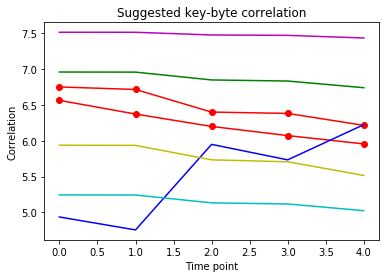

In [264]:
plt.plot(np.array(range(0,5)),  Log_theo_GM, 'r-o',np.array(range(0,5)),  Log_avg_GM_Lap, 'r-o',np.array(range(0,5)),  Log_avg_GE_Lap, 'b',np.array(range(0,5)),  Log_avg_up_Lap, 'g',np.array(range(0,5)),  Log_avg_low_Lap,'c',np.array(range(0,5)),  Log_up_GMHK_Lap,'m',np.array(range(0,5)),  Log_low_GMHK_Lap,'y')
plt.title('Suggested key-byte correlation')
plt.xlabel('Time point')
plt.ylabel('Correlation')

In [133]:
#FSE estimation
#LP_matrix is the log of probability matrix, each column corresponses to one byte,
#Number of rows equals to number of value for each byte
#Nb is the number of bins of Histogram for each byte
def Histogram_generator(LP_matrix,Nb):
    min_value = round(LP_matrix.min(),2)
    max_value = round(LP_matrix.max(),2)
    width = (max_value-min_value)/Nb
    central_value = [min_value+width*(i+0.5) for i in range(0,Nb)]
    H = np.zeros([LP_matrix.shape[1],Nb])
    for i in range(0,LP_matrix.shape[1]):
        for j in range(0,LP_matrix.shape[0]):
            H[i,np.where(abs(central_value-LP_matrix[j,i])==min(abs(central_value-LP_matrix[j,i])))[0][0]]+=1
    return {"width_of_histogram":width, "central_value":central_value,"H_matrix":H}

def convolve_Histogram(H):
    con_H = H[0,:]
    for i in range(1,H.shape[0]):
        con_H = np.convolve(con_H,H[i,:])
    return con_H

#convolve_central_vector requires input from function Histogram_generator
def convolve_central_vector(result , N):
    lenth = len(result["central_value"])
    return [result["central_value"][0]*(N+1) + i*result["width_of_histogram"] for i in range(0,(N+1)*lenth-N)]

def FSE_estimation(LP_matrix, Nb, kc):
    

In [79]:
LP_matrix = np.array([[0,0.02,0],[0.02,0.02,0.04],[0.07,0.036,0.06],[0.11,0.04,0.14],[0.14,0.12,0.15],[0.16,0.19,0.18],[0.19,0.24,0.21],[0.3,0.29,0.28]])

In [36]:
#Multiple bytes case
#Output lower bound and upper bound
def Calculate_GM_by_post_pro():
    